In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from metpy.calc import wind_components
from metpy.units import units
from scipy.stats import zscore

In [21]:
aqaba = pd.read_csv('Datasets\\Aqaba.csv', parse_dates=["Date/Time"])
ghor = pd.read_csv('Datasets\\Ghor El Safi.csv')
irbid = pd.read_csv('Datasets\\Irbid.csv')
irwaished = pd.read_csv('Datasets\\Irwaished.csv')
maan = pd.read_csv('Datasets\\Maan.csv')
mafraq = pd.read_csv('Datasets\\Mafraq.csv')
amman = pd.read_csv('Datasets\\Queen Alia Airport copy.csv')
safawi = pd.read_csv('Datasets\\Safawi.csv')

In [22]:
datasets = [aqaba, ghor, irbid, irwaished, maan, mafraq, amman, safawi]

In [23]:
for dataset in datasets:
    dataset.drop(['Station', 'Manual Present Weather', 'Snow Depth', 'Clouds Cover (Okta)', 'Cloud Type', 'Wind Type', 'Horizontal Visibility In m.'], axis=1, inplace=True)
    dataset['Liquid Precipitation'].fillna(0, inplace = True)
    dataset['Cloud Cover %'].fillna(0, inplace = True)

C:\Users\abood\AppData\Local\Temp\ipykernel_9856\2232920278.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Liquid Precipitation'].fillna(0, inplace = True)
C:\Users\abood\AppData\Local\Temp\ipykernel_9856\2232920278.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [25]:
datasets[6].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336486 entries, 0 to 336485
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Date/Time                 336486 non-null  object 
 1   Air Dew Point             333150 non-null  float64
 2   Air Temperature (OC)      333620 non-null  float64
 3   Humidity %                332892 non-null  float64
 4   Atmospheric Pressure      99914 non-null   float64
 5   Liquid Precipitation      336486 non-null  float64
 6   Cloud Cover %             336486 non-null  float64
 7   Wind Direction (Degrees)  243783 non-null  float64
 8   Wind Speed (MPS)          333360 non-null  float64
dtypes: float64(8), object(1)
memory usage: 23.1+ MB


In [26]:
datasets_1 = []
for dataset in datasets:
    data = dataset.copy()
    data = data.set_index("Date/Time")
    for col in data.columns:
        data[col] = data.groupby(data.index)[col].transform(lambda x: x.ffill().bfill())
    
    data = data[~data.index.duplicated(keep='first')]
    data.index = pd.to_datetime(data.index)
    data = data[data.index.year.isin(list(range(2000, 2024)))]
    date_range = pd.date_range(start = data.index.min(),end =data.index.max(), freq="D")
    missing_dates = date_range[~date_range.isin(data.index)]
    full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')
    data = data.reindex(full_range)
    data = data.ffill().bfill()
    for column in data.columns:
      data[column] = data[column].interpolate(method='ffill')
      data[column] = data[column].interpolate(method='bfill')
        
    u, v = wind_components(
        data['Wind Speed (MPS)'].values * units('m/s'),
        data['Wind Direction (Degrees)'].values * units.degree
    )

    data['Wind_U'] = u.magnitude  
    data['Wind_V'] = v.magnitude

    data.Wind_U = data.Wind_U.round(2)
    data.Wind_V = data.Wind_V.round(2)

    data.drop(['Wind Speed (MPS)', 'Wind Direction (Degrees)'], axis=1, inplace=True)

    datasets_1.append(data)

C:\Users\abood\AppData\Local\Temp\ipykernel_9856\2154180288.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')
C:\Users\abood\AppData\Local\Temp\ipykernel_9856\2154180288.py:17: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[column] = data[column].interpolate(method='ffill')
C:\Users\abood\AppData\Local\Temp\ipykernel_9856\2154180288.py:18: FutureWarning: Series.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[column] = data[column].interpolate(method='bfill')
C:\Users\abood\AppData\Local\Temp\ipykernel_9856\2154180288.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=data.index.min()

In [44]:
datasets_2 = datasets_1
for i in range(len(datasets_1)):
    for col in ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %', 'Atmospheric Pressure']:
        score = zscore(datasets_2[i][col])

        
        score = pd.Series(score, index=datasets_2[i][col].dropna().index)

        # Mask outliers (|z| > 3)
        outlier_mask = score.abs() > 3
        datasets_2[i].loc[outlier_mask, col] = np.nan

        # Interpolate and fill missing values
        datasets_2[i][col] = datasets_2[i][col].interpolate(method='time')
        datasets_2[i][col] = datasets_2[i][col].ffill().bfill()

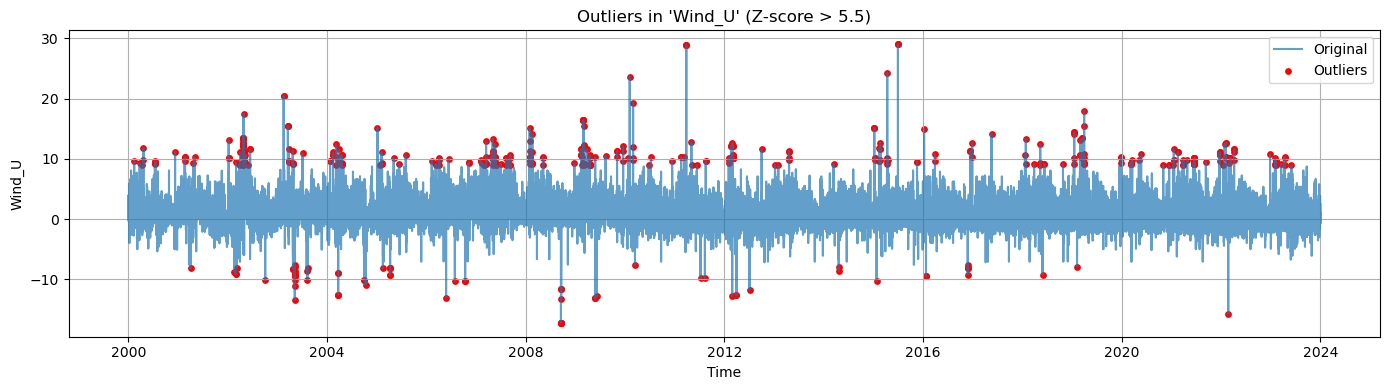

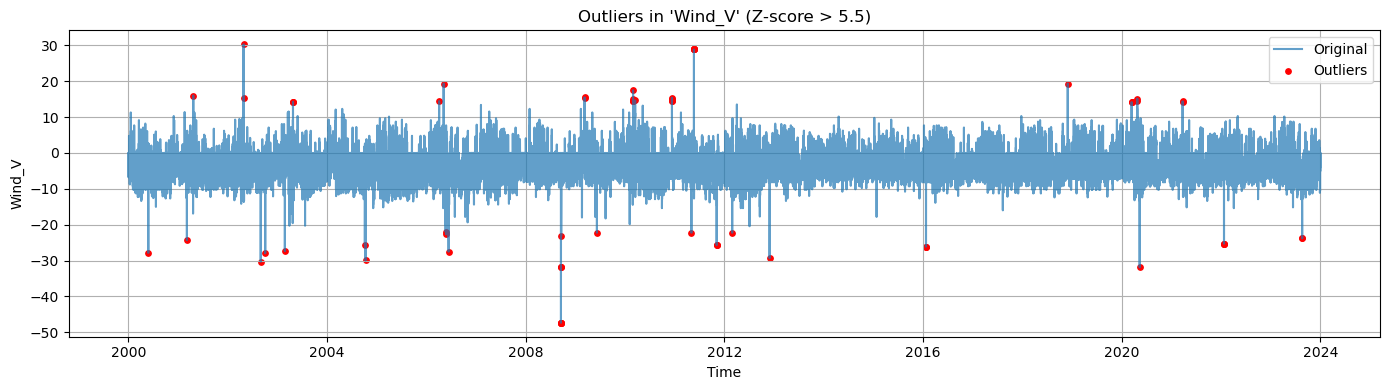

In [48]:
df = datasets_2[0]
# Compute Z-scores for numerical columns
z_scores = df.select_dtypes(include=[np.number]).apply(zscore)
threshold = 4.5

# Identify outliers
outliers_mask = z_scores.abs() > threshold

# Plot each variable with outliers highlighted
for col in ['Wind_U', 'Wind_V']:
    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df[col], label='Original', alpha=0.7)
    plt.scatter(df.index[outliers_mask[col]], df[col][outliers_mask[col]], 
                color='red', label='Outliers', s=15)
    plt.title(f"Outliers in '{col}' (Z-score > {threshold})")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [49]:
for i in range(len(datasets_2)):
    score = zscore(datasets_2[i]['Wind_U'])

        
    score = pd.Series(score, index=datasets_2[i]['Wind_U'].dropna().index)


    outlier_mask = score.abs() > 5.6
    datasets_2[i].loc[outlier_mask, 'Wind_U'] = np.nan

    # Interpolate and fill missing values
    datasets_2[i]['Wind_U'] = datasets_2[i]['Wind_U'].interpolate(method='time')
    datasets_2[i]['Wind_U'] = datasets_2[i]['Wind_U'].ffill().bfill()

In [50]:
for i in range(len(datasets_2)):
    score = zscore(datasets_2[i]['Wind_V'])

        
    score = pd.Series(score, index=datasets_2[i]['Wind_V'].dropna().index)


    outlier_mask = score.abs() > 4.5
    datasets_2[i].loc[outlier_mask, 'Wind_V'] = np.nan

    # Interpolate and fill missing values
    datasets_2[i]['Wind_V'] = datasets_2[i]['Wind_V'].interpolate(method='time')
    datasets_2[i]['Wind_V'] = datasets_2[i]['Wind_V'].ffill().bfill()

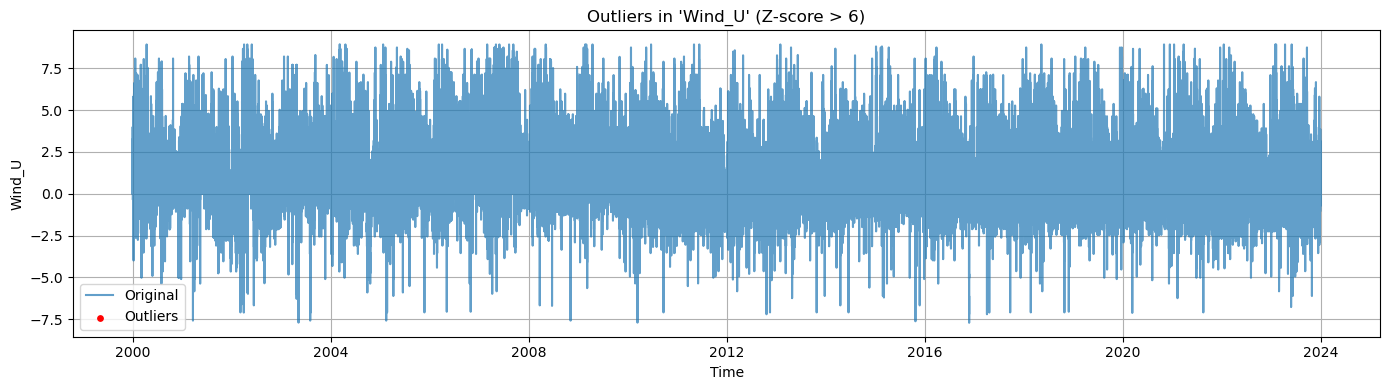

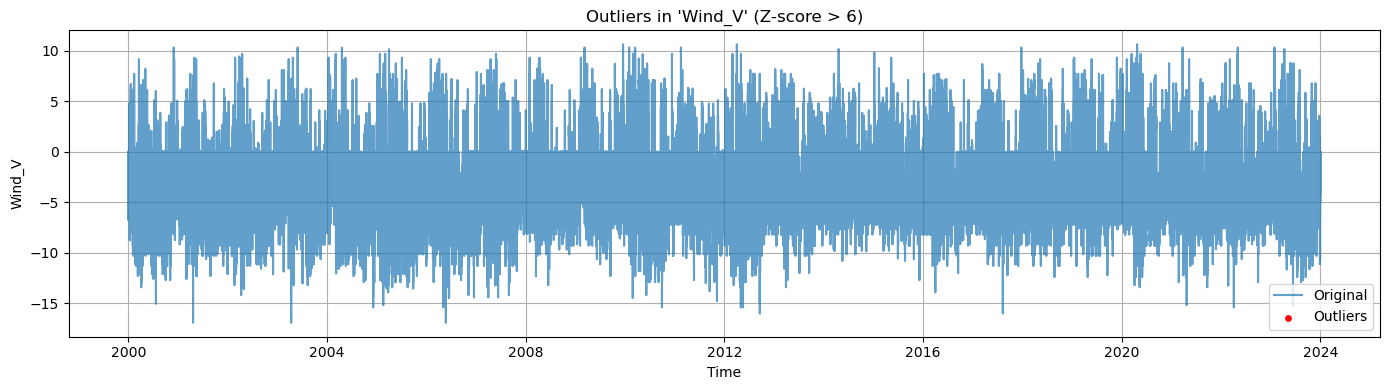

In [51]:
df = datasets_2[0]
# Compute Z-scores for numerical columns
z_scores = df.select_dtypes(include=[np.number]).apply(zscore)
threshold = 6

# Identify outliers
outliers_mask = z_scores.abs() > threshold

# Plot each variable with outliers highlighted
for col in ['Wind_U', 'Wind_V']:
    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df[col], label='Original', alpha=0.7)
    plt.scatter(df.index[outliers_mask[col]], df[col][outliers_mask[col]], 
                color='red', label='Outliers', s=15)
    plt.title(f"Outliers in '{col}' (Z-score > {threshold})")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [55]:
for dataset in datasets_2:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210384 entries, 2000-01-01 00:00:00 to 2023-12-31 23:00:00
Freq: h
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Air Dew Point         210384 non-null  float64
 1   Air Temperature (OC)  210384 non-null  float64
 2   Humidity %            210384 non-null  float64
 3   Atmospheric Pressure  210384 non-null  float64
 4   Liquid Precipitation  210384 non-null  float64
 5   Cloud Cover %         210384 non-null  float64
 6   Wind_U                210384 non-null  float64
 7   Wind_V                210384 non-null  float64
dtypes: float64(8)
memory usage: 14.4 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210382 entries, 2000-01-01 00:00:00 to 2023-12-31 21:00:00
Freq: h
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Air Dew Point        

In [56]:
datasets_2[6].drop(['RainNextDay'], axis = 1, inplace = True)

In [57]:
Final_data = []
for df in datasets_2:
    
    df['Cloud Cover %'] = df['Cloud Cover %'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')
    Final_data.append(df)

C:\Users\abood\AppData\Local\Temp\ipykernel_9856\262782296.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Cloud Cover %'] = df['Cloud Cover %'].rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')


In [61]:
for i in range(len(Final_data)):
    for col in Final_data[i].columns:
        Final_data[i][col] = round(Final_data[i][col], 2)
        

In [63]:
import os


names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
for i in range(len(Final_data)):
    Final_data[i].to_csv(names[i]+'_Ready.csv')